In [1]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat
from scipy.interpolate import interp2d, NearestNDInterpolator

import os
os.getcwd()

%cd /g/data/p66/ars599/EAE_Lecture/Ocean/

/g/data/p66/ars599/EAE_Lecture/Ocean


In [2]:
idir = '/g/data/p66/ars599/work_eae/'
filenames = [idir+'uo_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc',
            idir+'vo_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc',
            idir+'wo_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc',
            idir+'thetao_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc']

file_list = []

for filename in filenames:
    ds = xr.open_dataset(filename)
    file_list.append(ds)


In [3]:
# Assuming your dataset is named ds - uo
ds = file_list[0]

# Assuming uo is the uo variable from your xarray.Dataset (ds)
uo = ds.uo

In [4]:
# Assuming your dataset is named ds - vo
ds = file_list[1]

# Assuming vo is the vo variable from your xarray.Dataset (ds)
vo = ds.vo

In [5]:
# Assuming your dataset is named ds - theta
ds = file_list[3]

# Assuming vo is the vo variable from your xarray.Dataset (ds)
theta = ds.thetao

In [6]:
# Assuming your dataset is named ds
ds = file_list[2]

# Assuming vo is the vo variable from your xarray.Dataset (ds)
wo = ds.wo

## Calculate the spatial maps of both of these advection terms in the upper layer 

In [7]:
def calculate_n3_anom(var, ystart, ylast):
    ystart_str = str(ystart).zfill(4)
    ylast_str = str(ylast).zfill(4)
    var = var.sel(time=slice(ystart_str, ylast_str))
    var_clim = var.groupby("time.month").mean(dim="time")
    var_anom = var.groupby("time.month") - var_clim
    return var_anom

In [8]:
# Assuming uo is the zonal current variable from your xarray.Dataset (ds)
uo_anom = calculate_n3_anom(uo,2000,2009)
vo_anom = calculate_n3_anom(vo,2000,2009)
#wo_anom = calculate_n3_anom(wo,2000,2009)
theta_anom = calculate_n3_anom(theta,2000,2009)

uo_bar = uo - uo_anom
vo_bar = vo - vo_anom
#wo_bar = wo - wo_anom
theta_bar = theta - theta_anom


In [9]:
tNum, lNum, jNum, iNum = theta.shape
gradT_x = theta * 0
gradT_y = theta * 0
for l in range(lNum):
    for m in range(tNum):
        gradT_y[m, l, :, :], gradT_x[m, l, :, :] = np.gradient(theta[m,l,:,:], -np.deg2rad(.75), np.deg2rad(.75))
gradT_x.name = 'Gradient of theta along x'
gradT_y.name = 'Gradient of theta along y'

gradTa_x = theta_anom * 0
gradTa_y = theta_anom * 0
for l in range(lNum):
    for m in range(tNum):
        gradTa_y[m, l, :, :], gradTa_x[m, l, :, :] = np.gradient(theta_anom[m,l,:,:], -np.deg2rad(.75), np.deg2rad(.75))
gradTa_x.name = 'Gradient of theta prime along x'
gradTa_y.name = 'Gradient of theta prime along y'

gradTb_x = theta_bar * 0
gradTb_y = theta_bar * 0
for l in range(lNum):
    for m in range(tNum):
        gradTb_y[m, l, :, :], gradTb_x[m, l, :, :] = np.gradient(theta_bar[m,l,:,:], -np.deg2rad(.75), np.deg2rad(.75))
gradTb_x.name = 'Gradient of theta bar along x'
gradTb_y.name = 'Gradient of theta bar along y'


In [10]:
'''

using directly from gradient

'''
# Assuming theta is a 4D array with dimensions (tNum, lNum, jNum, iNum)

# Calculate gradient along the time axis
gradT_t = np.gradient(theta, axis=0)
gradT_t = theta * 0 + gradT_t
gradT_t.name = 'Gradient of theta along time'

# Calculate gradient along the level axis
gradT_lev = np.gradient(theta, axis=1)
gradT_lev = theta * 0 + gradT_lev
gradT_lev.name = 'Gradient of theta along lev'

gradTa_lev = np.gradient(theta_anom, axis=1)
gradTa_lev = theta_anom * 0 + gradTa_lev
gradTa_lev.name = 'Gradient of theta along lev'

gradTb_lev = np.gradient(theta_bar, axis=1)
gradTb_lev = theta_bar * 0 + gradTb_lev
gradTb_lev.name = 'Gradient of theta along lev'

In [11]:
'''
now combine all the cases

'''
zon_adv = gradT_x * uo
TbUb = gradTb_x * uo_bar
TaUb = gradTa_x * uo_bar
TbUa = gradTb_x * uo_anom
TaUa = gradTa_x * uo_anom

meri_adv = gradT_y * vo
TbVb = gradTb_y * vo_bar
TaVb = gradTa_y * vo_bar
TbVa = gradTb_y * vo_anom
TaVa = gradTa_y * vo_anom

## Prepare W to fit T vertical grid !!!!

In [12]:
from scipy.interpolate import interp1d
# Assuming T is on grid [5., 15., 25., ..., 105.] and W is on grid [10., 20., 30., ..., 120.]
# Interpolate W to the grid of T
W_levels = wo.lev.values
T_levels = theta.lev.values

# Create fake data at depth 0
fake_data_at_0 = wo.isel(lev=0) * 0.5  # You can adjust the factor as needed

# Interpolate to target depths
wo_interp = interp1d(W_levels, wo, axis=1, kind='linear', bounds_error=False)(T_levels)
# Create a new DataArray with interpolated values and coordinates
wo_interp_da = xr.DataArray(wo_interp, coords={'latitude': wo.latitude, 'longitude': wo.longitude, 'i': wo.i, 'j': wo.j, 'time': wo.time, 'lev': T_levels}, dims=('time', 'lev', 'j', 'i'))
wo_interp_da[:,0,:,:] = fake_data_at_0


In [13]:
wo_anom = calculate_n3_anom(wo_interp_da,2000,2009)
wo_bar = wo_interp - wo_anom

# Now w_interp has the same vertical grid as T, and you can multiply dT_dlev with w_interp
vert_adv = gradT_lev * wo_interp_da
TaWa = gradTa_lev * wo_anom
TaWb = gradTa_lev * wo_bar
TbWa = gradTb_lev * wo_anom
TbWb = gradTb_lev * wo_bar


## save to files

In [14]:
import xarray as xr

def interpolate_with_reference(varialb, reference):
    '''
    # Example usage:
    # interpolated_zonal_advection = interpolate_with_reference(zonal_advection, gradT_t)
    '''
    # Ensure both variables have the same dimensions
    if not varialb.dims == reference.dims:
        raise ValueError("Dimensions of varialb and reference must match.")

    # Interpolate varialb using reference
    interpolated = varialb.interp_like(reference)

    # Copy coordinates from reference to interpolated
    interpolated = interpolated.assign_coords(**reference.coords)

    return interpolated

zonal_adv = interpolate_with_reference(zon_adv, gradT_t)
meridional_adv = interpolate_with_reference(meri_adv, gradT_t)
vertical_adv = interpolate_with_reference(vert_adv, gradT_t)

In [15]:
# Create a zonal advection Dataset containing the DataArrays
data_dict = {
    'dT_dt' : gradT_t,
    'zonal_advection': zonal_adv,
    'TbUb': TbUb,
    'TaUb': TaUb,
    'TbUa': TbUa,
    'TaUa': TaUa,
    'meridional_advection': meridional_adv,
    'TbVb': TbVb,
    'TaVb': TaVb,
    'TbVa': TbVa,
    'TaVa': TaVa,
    'vertical_advection': vertical_adv,
    'TbWb': TbWb,
    'TaWb': TaWb,
    'TbWa': TbWa,
    'TaWa': TaWa
}
ds = xr.Dataset(data_dict)

# Save the Dataset to a netCDF file
ds.to_netcdf('temperature_tendency_inmeters_v2.nc')


### Generate a 2x3 contour plot

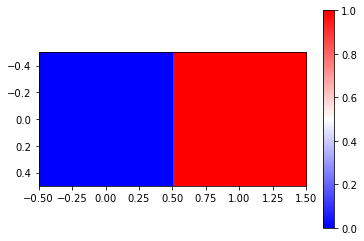

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
colors = [
    (0.0000000e+00, 0.0000000e+00, 1.0000000e+00),
    (1.0000000e-01, 1.0000000e-01, 1.0000000e+00),
    (2.0000000e-01, 2.0000000e-01, 1.0000000e+00),
    (3.0000000e-01, 3.0000000e-01, 1.0000000e+00),
    (4.0000000e-01, 4.0000000e-01, 1.0000000e+00),
    (5.0000000e-01, 5.0000000e-01, 1.0000000e+00),
    (6.0000000e-01, 6.0000000e-01, 1.0000000e+00),
    (7.0000000e-01, 7.0000000e-01, 1.0000000e+00),
    (8.0000000e-01, 8.0000000e-01, 1.0000000e+00),
    (9.0000000e-01, 9.0000000e-01, 1.0000000e+00),
    (1.0000000e+00, 1.0000000e+00, 1.0000000e+00),
    (1.0000000e+00, 9.0000000e-01, 9.0000000e-01),
    (1.0000000e+00, 8.0000000e-01, 8.0000000e-01),
    (1.0000000e+00, 7.0000000e-01, 7.0000000e-01),
    (1.0000000e+00, 6.0000000e-01, 6.0000000e-01),
    (1.0000000e+00, 5.0000000e-01, 5.0000000e-01),
    (1.0000000e+00, 4.0000000e-01, 4.0000000e-01),
    (1.0000000e+00, 3.0000000e-01, 3.0000000e-01),
    (1.0000000e+00, 2.0000000e-01, 2.0000000e-01),
    (1.0000000e+00, 1.0000000e-01, 1.0000000e-01),
    (1.0000000e+00, 0.0000000e+00, 0.0000000e+00)
]

# Create the colormap
shayne_cmap = LinearSegmentedColormap.from_list("shayne_cmap", colors)

# Now you can use your custom colormap for plotting
plt.imshow([[0, 1]], cmap=shayne_cmap)
plt.colorbar()
plt.show()


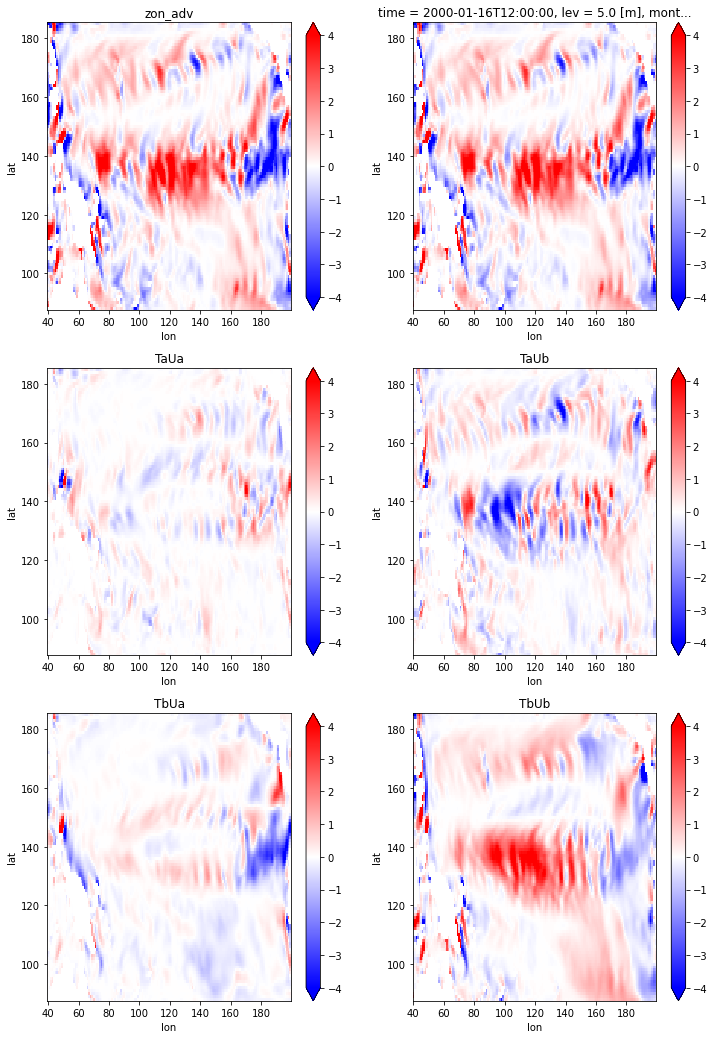

In [24]:
fig, axs = plt.subplots(figsize=(12, 18))

axs = plt.subplot(321)
(zon_adv[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('zon_adv')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

total_TU = TaUa + TaUb + TbUa + TbUb

axs = plt.subplot(322)
(total_TU[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(323)
(TaUa[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('TaUa')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(324)
(TaUb[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('TaUb')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(325)
(TbUa[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('TbUa')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(326)
(TbUb[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('TbUb')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

output_filename = f"zonal_adv_testunits_v2.png"
plt.savefig(output_filename, dpi=300)

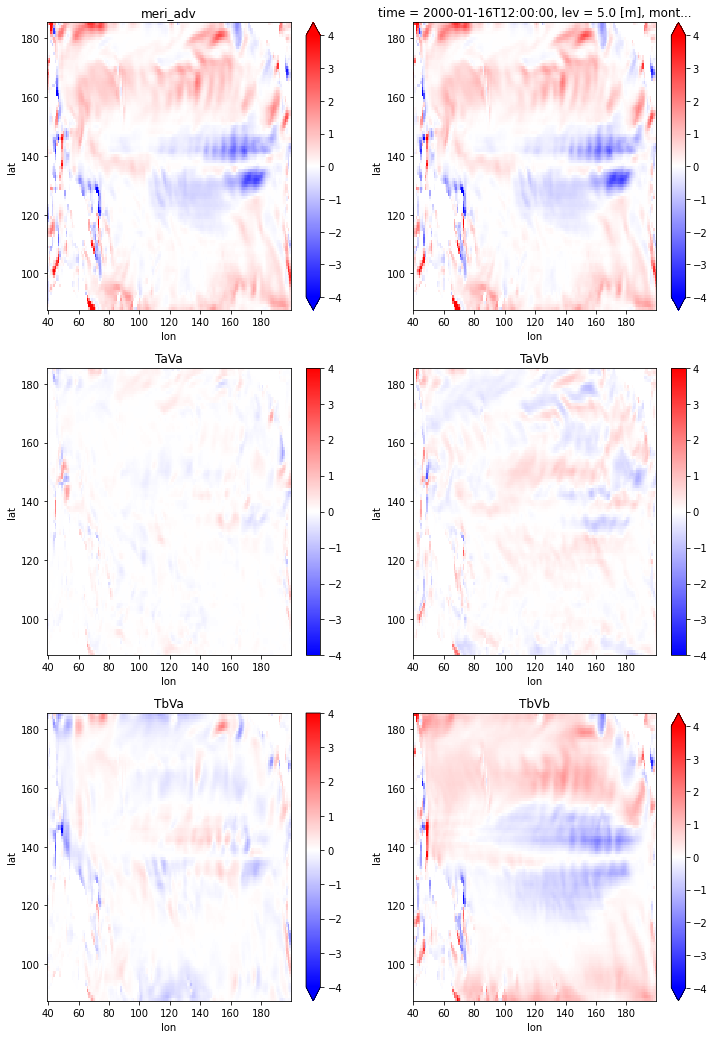

In [25]:
fig, axs = plt.subplots(figsize=(12, 18))

axs = plt.subplot(321)
(meri_adv[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('meri_adv')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

total_TV = TaVa + TaVb + TbVa + TbVb

axs = plt.subplot(322)
(total_TV[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(323)
(TaVa[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('TaVa')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(324)
(TaVb[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('TaVb')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(325)
(TbVa[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('TbVa')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(326)
(TbVb[0, 0, :, :]).plot(vmin=-4, vmax=4, cmap=shayne_cmap)
axs.set_title('TbVb')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

output_filename = f"merional_adv_testunits_v2.png"
plt.savefig(output_filename, dpi=300)

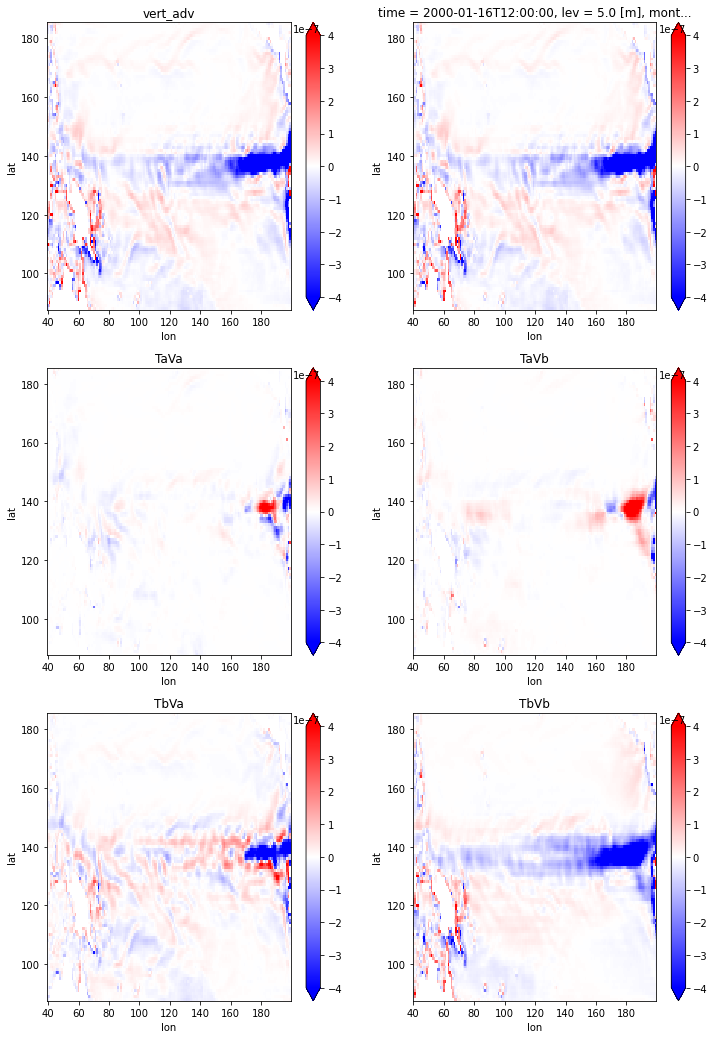

In [30]:
fig, axs = plt.subplots(figsize=(12, 18))

axs = plt.subplot(321)
(vert_adv[0, 0, :, :]).plot(vmin=-4e-7, vmax=4e-7, cmap=shayne_cmap)
axs.set_title('vert_adv')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

total_TW = TaWa + TaWb + TbWa + TbWb

axs = plt.subplot(322)
(total_TW[0, 0, :, :]).plot(vmin=-4e-7, vmax=4e-7, cmap=shayne_cmap)
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(323)
(TaWa[0, 0, :, :]).plot(vmin=-4e-7, vmax=4e-7, cmap=shayne_cmap)
axs.set_title('TaVa')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(324)
(TaWb[0, 0, :, :]).plot(vmin=-4e-7, vmax=4e-7, cmap=shayne_cmap)
axs.set_title('TaVb')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(325)
(TbWa[0, 0, :, :]).plot(vmin=-4e-7, vmax=4e-7, cmap=shayne_cmap)
axs.set_title('TbVa')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

axs = plt.subplot(326)
(TbWb[0, 0, :, :]).plot(vmin=-4e-7, vmax=4e-7, cmap=shayne_cmap)
axs.set_title('TbVb')
axs.set_xlabel('lon'); axs.set_ylabel('lat')

output_filename = f"vertical_adv_testunits_v2.png"
plt.savefig(output_filename, dpi=300)